In [37]:
import sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
from src import utils # this is our own library of functions
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np 
import seaborn as sns
import pandas as pd

sns.set_context("talk")
mkl.set_num_threads(10)
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
exp_db = []
exp_db = utils.add_exp(exp_db, 'DR10', '2022_07_11','1')
exp_db = utils.add_exp(exp_db, 'DR11', "2022_08_04","1")
exp_db = utils.add_exp(exp_db, 'DR12', "2022_08_04","1")
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_17', '1')
exp_db = utils.add_exp(exp_db, 'L1_A3', '2022_06_09', '2')
exp_db = utils.add_exp(exp_db, 'TX91', '2022_07_28', '2')
timeline_block = [None,None,None,None,None,None] # timeline block to select, when None it selects by default the timeline corresponding to the block in exp_db
frames_per_folder = [0,0,0,0,0,0] # when suite2p process multiple blocks you need to specify which one you want, 0 correspond to select the first block (ie, the first that suite2p processed)

In [4]:
Sessions = utils.build_sessions(exp_db, frames_per_folder, timeline_block, dual_plane=True, baseline=True)

Session: 0
planes: 20


100%|██████████| 20/20 [06:27<00:00, 19.35s/it]


total neurons: 56096
Session: 1
planes: 20


100%|██████████| 20/20 [05:06<00:00, 15.33s/it]


total neurons: 50810
Session: 2
planes: 20


100%|██████████| 20/20 [05:20<00:00, 16.03s/it]


total neurons: 54582
Session: 3
planes: 20


100%|██████████| 20/20 [06:18<00:00, 18.91s/it]


total neurons: 59181
Session: 4
planes: 20


100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


total neurons: 21119


c:\users\windesktopmp\documents\dprime\passivestim\src\utils.py:240: RuntimeWarning: invalid value encountered in true_divide
  ss = ss / np.mean(ss ** 2, 1)[:, np.newaxis, :] ** 0.5


Session: 5
planes: 20


100%|██████████| 20/20 [06:29<00:00, 19.47s/it]


total neurons: 73826


In [5]:
summ_id = []
summ_date = []
summ_block = []
summ_layer = []
summ_traintex = []
summ_acc = []
summ_margin = []
summ_catpair = []
summ_sess = []
n_categories = 8 
n_samples = 4
n_pairs = 28 
layers = [1,2]

In [44]:
for sess in range(len(exp_db)):
    acurracy_per_layer = []
    spop_per_layer = []
    neurons_per_layer = []
    margin_per_layer = []
    mean_margin_L1 = []
    mean_margin_L2 = []
    Sessions[sess].cats, Sessions[sess].stim_idx, Sessions[sess].nreps = utils.get_stim_class_and_samples_ix(Sessions[sess].subset_stim, n_categories=8, samples_per_cat=4)
    for layer in layers:
        accuracy, pairs, spops, cat_dict, selected_neurons = utils.PairwiseDprimeDecoder(Sessions[sess].neurons_atframes, Sessions[sess].stim_idx, Sessions[sess].iplane, Sessions[sess].cats,
                                                                        n_categories = n_categories, n_samples = n_samples, layer = layer , avg_reps = True)
        gen_marg = utils.get_generalization_margings(spops, n_pairs = n_pairs, n_textures = n_samples)
        acurracy_per_layer.append(accuracy)
        spop_per_layer.append(spops)
        margin_per_layer.append(gen_marg)
        neurons_per_layer.append(selected_neurons)

    for pair in range(n_pairs):
        mean_margin_L1.append(utils.get_margin_per_category(margin_per_layer[0],pair,avg=True))
        mean_margin_L2.append(utils.get_margin_per_category(margin_per_layer[1],pair,avg=True))

    Sessions[sess].acurracy_per_layer = np.array(acurracy_per_layer)
    Sessions[sess].spop_per_layer = np.array(spop_per_layer)
    Sessions[sess].dprime_neurons_per_layer = np.array(neurons_per_layer)
    Sessions[sess].margin_per_layer = np.array(margin_per_layer)
    Sessions[sess].mean_margin_L1 = np.array(mean_margin_L1)
    Sessions[sess].mean_margin_L2 = np.array(mean_margin_L2)
    Sessions[sess].cat_pairs = utils.categorypairs_parser(cat_dict,pairs)

    # create a summary 
    summ_id.append([Sessions[sess].name]*n_pairs*n_samples*len(layers))
    summ_date.append([Sessions[sess].date] * n_pairs*n_samples*len(layers))
    summ_block.append([Sessions[sess].block] * n_pairs*n_samples*len(layers))
    summ_sess.append(np.repeat(sess, n_pairs*n_samples*len(layers)))
    summ_layer.append(np.append(np.repeat(1,n_samples*n_pairs),np.repeat(2,n_samples*n_pairs)))
    summ_traintex.append(np.tile(np.tile(np.arange(n_samples),n_pairs),len(layers)))
    summ_acc.append(Sessions[sess].acurracy_per_layer.reshape((n_pairs*n_samples)*len(layers),-1).flatten())
    summ_margin.append(np.append(Sessions[sess].mean_margin_L1.reshape(n_pairs*n_samples,-1).flatten(),Sessions[sess].mean_margin_L2.reshape(n_pairs*n_samples,-1).flatten()))
    summ_catpair.append(np.tile(np.repeat(np.array(Sessions[sess].cat_pairs),n_samples),len(layers)))

summary_sessions = pd.DataFrame({
"Session": np.concatenate(np.array(summ_sess, dtype=object),axis=0),
"ID": np.concatenate(np.array(summ_id, dtype=object),axis=0),
"Date": np.concatenate(np.array(summ_date, dtype=object),axis=0),
"Block": np.concatenate(np.array(summ_block, dtype=object),axis=0),
"Layer": np.concatenate(np.array(summ_layer, dtype=object),axis=0),
"Training_tex" : np.concatenate(np.array(summ_traintex, dtype=object),axis=0),
"Accuracy": np.concatenate(np.array(summ_acc, dtype=object),axis=0),
"Margin": np.concatenate(np.array(summ_margin, dtype=object),axis=0),
"Category_Pair": np.concatenate(np.array(summ_catpair, dtype=object),axis=0)
})

summary_sessions.head()

8 categories, 32 exemplars, 25 repeats
8 categories, 32 exemplars, 28 repeats
8 categories, 32 exemplars, 26 repeats
8 categories, 32 exemplars, 98 repeats
8 categories, 32 exemplars, 173 repeats
8 categories, 32 exemplars, 41 repeats


,Session,ID,Date,Block,Layer,Training_tex,Accuracy,Margin,Category_Pair
0,0,DR10,2022_07_11,1,1,0,100.0,0.137255,leaves/circles
1,0,DR10,2022_07_11,1,1,1,100.0,0.149098,leaves/circles
2,0,DR10,2022_07_11,1,1,2,75.0,0.122631,leaves/circles
3,0,DR10,2022_07_11,1,1,3,100.0,0.247694,leaves/circles
4,0,DR10,2022_07_11,1,1,0,75.0,0.116608,leaves/dryland


In [45]:
def cortex_sliding_window(xpos, ypos, w=1000, s=500, k=-1):
    '''
    :param w: sliding window size, (w, w).
    :param s: sliding stride.
    :param k: number of neurons selected in each area. if k is -1, use all neurons in that window to do classification.
    :return: 
    assume there are M areas which have at least k neurons.
    win_positions: positions of windows, shape (M, 4), each row means (xmin, ymin, xmax, ymax) of each area.
    neuron_idxs: neuron indexes within each area, shape (M, k)
    '''
    ymin, ymax = np.min(ypos), np.max(ypos)
    xmin, xmax = np.min(xpos), np.max(xpos)
    win_positions = []
    neuron_idxs = []
    xstart, ystart = 0, 0
    xend, yend = w - 1, w - 1
    
    while True:
        while True:
            idx = np.where((xstart<=xpos)&(xpos<=xend)&(ystart<=ypos)&(ypos<=yend))[0]
            # only record areas with more than k neurons
            if k == -1:
                win_positions.append(np.array([xstart, ystart, xend, yend]))
                neuron_idxs.append(idx)
            elif len(idx) >= k:
                win_positions.append(np.array([xstart, ystart, xend, yend]))
                # print(win_positions[-1])
                irand = np.random.choice(len(idx), k, replace=False)
                neuron_idxs.append(idx[irand])
            if xend >= (xmax - 1):
                break
            xend += min(s, xmax - xend - 1)
            xstart = xend - w + 1
        xstart = 0
        xend = w - 1
        if yend >= (ymax - 1):
            break
        yend += min(s, ymax-yend-1)
        ystart = yend - w + 1
        
    win_positions = np.vstack(win_positions)
    # neuron_idxs = np.vstack(neuron_idxs)
    print('Get neurons in each area done!')
    #print('window positions: ', win_positions.shape)
#     print('neuron indexes: ')
#     for nidxs in neuron_idxs:
#         print(nidxs.shape)
    return win_positions, neuron_idxs

Get window idxs:

Get neurons in each area done!
59178 0 59180


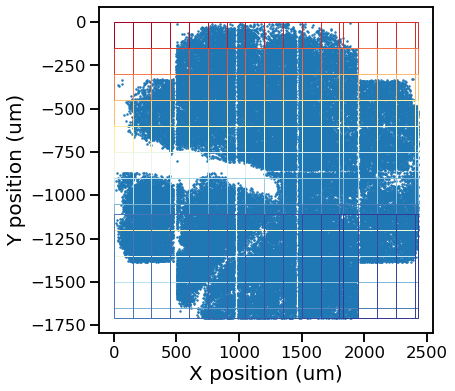

In [46]:
window_size = 600
stride = int(window_size / 4)
least_neurons_per_area = 1000
window_pos, neuron_index = cortex_sliding_window(Sessions[3].xpos, Sessions[3].ypos, w=window_size, s=stride, k=-1)
flat_nidx = np.hstack(neuron_index)
idxes = np.unique(flat_nidx)
print(len(idxes), idxes.min(), idxes.max())
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter( Sessions[3].xpos[idxes], -Sessions[3].ypos[idxes],  s = 1)
ax.set_xlabel('X position (um)', fontsize=20)
ax.set_ylabel('Y position (um)', fontsize=20)
n_areas = window_pos.shape[0]
for i in range(n_areas):
    xmin, ymin, xmax, ymax = window_pos[i]
    ax.add_patch(Rectangle(xy=(xmin, -ymax), width=window_size, height=window_size, color=plt.cm.RdYlBu(i/n_areas), linewidth=1, fill=False))
plt.show()

In [47]:
def DprimeDecoderWindowed(Session: object, idx_perwindow: np.array,  n_categories: int = 8, n_samples: int = 4, n_pairs: int = 28, layer: int = 1):
    """
    Fits the DprimeDecoder on each window, returns accuracy, spop, dprime neurons, and margins, per window
    """
    accuracy_per_win = []
    spop_per_win = []
    dprime_neurons_per_win = []
    margin_per_win = []
    for win in range(n_areas):
        mask = idx_perwindow[win]
        neurons_atframes_win = Session.neurons_atframes[mask]
        iplane_win = Session.iplane[mask]
        accuracy, _ , spops, _ , selected_neurons = utils.PairwiseDprimeDecoder(neurons_atframes_win, Session.stim_idx, iplane_win, Session.cats,
                                                                        n_categories = n_categories, n_samples = n_samples, layer = layer , avg_reps = True)
        gen_marg = utils.get_generalization_margings(spops, n_pairs = n_pairs, n_textures = n_samples)
        accuracy_per_win.append(accuracy)
        spop_per_win.append(spops)
        margin_per_win.append(gen_marg)
        dprime_neurons_per_win.append(selected_neurons)
    return np.array(accuracy_per_win), np.array(spop_per_win), np.array(margin_per_win), np.array(dprime_neurons_per_win)

In [48]:
accuracy_per_win, spop_per_win, margin_per_win, dprime_neurons_per_win = DprimeDecoderWindowed(Sessions[3], neuron_index,  n_categories = n_categories, n_samples = n_samples, n_pairs = n_pairs, layer= 1)

Gets the overall margin and acc per window

In [49]:
def get_overall_metrics(accuracy_per_win: np.array, margin_per_win: np.array, window_pos: np.array, n_pairs: int = 28):
    """
    Computes the overall accuracy and margin per window
    """
    overall_margin_perwin = []
    overall_acc_perwin = []
    n_areas = window_pos.shape[0]
    for win in range(n_areas):
        catpair_mean_margin = []
        overall_acc_perwin.append(accuracy_per_win[win].mean())
        for pair in range(n_pairs):
            margin_per_catpair = utils.get_margin_per_category(margin_per_win[win],pair,avg=True).mean()
            catpair_mean_margin.append(margin_per_catpair)
        overall_window_margin = np.array(catpair_mean_margin).mean()
        overall_margin_perwin.append(overall_window_margin)
    return np.array(overall_acc_perwin), np.array(overall_margin_perwin)

In [50]:
overall_acc_perwin, overall_margin_perwin = get_overall_metrics(accuracy_per_win, margin_per_win, window_pos, n_pairs = n_pairs)

In [51]:
def cast_overall_metrics_toneurons(Session: object, overall_acc_perwin: np.array, overall_margin_perwin: np.array,  neuron_index: np.array):
    """
    Casts the metric to neurons by averaging them through shared windows (i.e, neurons can be on several windows, and get different metrics, average over those windows) 
    """
    n_neurons = Session.neurons_atframes.shape[0]
    n_areas = len(neuron_index)
    neu_margings_perwin = np.empty((n_neurons, n_areas), dtype=object)
    neu_acc_perwin = np.empty((n_neurons, n_areas), dtype=object)
    for area_id in range(n_areas):
        margin_atarea = overall_margin_perwin[area_id]
        acc_atarea = overall_acc_perwin[area_id]
        neu_idx_in_area = neuron_index[area_id]
        for neuron in neu_idx_in_area:
            neu_margings_perwin[neuron,area_id] = margin_atarea
            neu_acc_perwin[neuron,area_id] = acc_atarea
    mar_neu_notin_areaid = pd.isnull(neu_margings_perwin)
    acc_neu_notin_areaid = pd.isnull(neu_acc_perwin)
    margin_per_neuron = []
    acc_per_neuron = []
    for neuron in range(n_neurons):
        if np.sum(~acc_neu_notin_areaid[neuron]) == 0:
            acc_per_neuron.append(np.nan)
        else:
            average_acc_per_neuron = neu_acc_perwin[neuron,~acc_neu_notin_areaid[neuron]].mean()
            acc_per_neuron.append(average_acc_per_neuron)
        if np.sum(~mar_neu_notin_areaid[neuron]) == 0:
            margin_per_neuron.append(np.nan)
        else:
            average_margin_per_neuron = neu_margings_perwin[neuron,~mar_neu_notin_areaid[neuron]].mean()
            margin_per_neuron.append(average_margin_per_neuron)
    return np.array(margin_per_neuron), np.array(acc_per_neuron)

In [52]:
margin_per_neuron, acc_per_neuron = cast_overall_metrics_toneurons(Sessions[3], overall_acc_perwin, overall_margin_perwin, neuron_index)

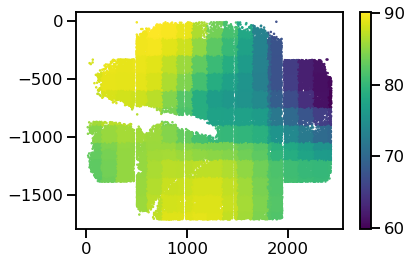

In [53]:
cm = plt.cm.get_cmap('viridis')
sc = plt.scatter(Sessions[3].xpos[~np.isnan(acc_per_neuron)],-Sessions[3].ypos[~np.isnan(acc_per_neuron)], s=1, cmap=cm, c = acc_per_neuron[~np.isnan(acc_per_neuron)]) 
plt.colorbar(sc)

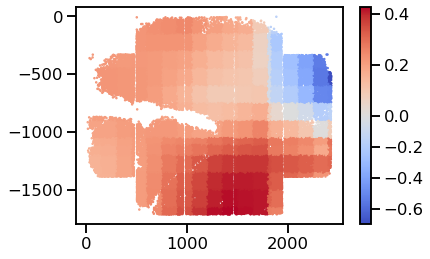

In [54]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(Sessions[3].xpos[~np.isnan(margin_per_neuron)],-Sessions[3].ypos[~np.isnan(margin_per_neuron)], s=1, cmap='coolwarm', c = margin_per_neuron[~np.isnan(margin_per_neuron)], norm=colors.TwoSlopeNorm(vcenter = 0))
plt.colorbar(sc)

# Agreement analysis 

## Select neurons that belong to windows with both top n accuracy and margin

In [55]:
def get_consistent_neurons(overall_margin_perwin,overall_acc_perwin, n=20, verbose=False):
    topn_marg = np.argsort(overall_margin_perwin)[::-1][:n]
    topn_acc = np.argsort(overall_acc_perwin)[::-1][:n]
    consistent_win, counts = np.unique(np.concatenate([topn_acc,topn_marg]),return_counts=True)
    consistent_win = consistent_win[counts>1]
    consistent_neurons = []
    for win in consistent_win:
        consistent_neurons.append(neuron_index[win])
    assert len(consistent_neurons)>0, 'non overlapping windows, increase "n"'
    consistent_neurons = np.concatenate(consistent_neurons, axis=0)
    if verbose:
        print(f'********* Top {n} window accuracies: *********')
        print(f'{np.sort(overall_acc_perwin)[::-1][:n]}')
        print(f'idxs : {np.argsort(overall_acc_perwin)[::-1][:n]}')
        print(f'********* Top {n} window margins: *********')
        print(f'{np.sort(overall_margin_perwin)[::-1][:n]}')
        print(f'idxs : {np.argsort(overall_margin_perwin)[::-1][:n]}')
    return np.unique(consistent_neurons)


In [56]:
consistent_neurons = get_consistent_neurons(overall_margin_perwin,overall_acc_perwin, n=20)

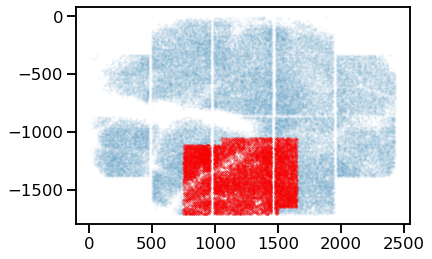

In [57]:
plt.scatter(Sessions[3].xpos,-Sessions[3].ypos, s=0.2,alpha=0.1)
plt.scatter(Sessions[3].xpos[consistent_neurons],-Sessions[3].ypos[consistent_neurons], c='r',s=0.2, alpha =0.5)

# Across Mice and layers
# ** This will take time!!! ** 

In [72]:
window_size = 600
stride = int(window_size / 4)
least_neurons_per_area = 1000
n_sessions = len(Sessions)
n_layers = len(layers)
#for sess in range(n_sessions):
for sess in [4]:
    Sessions[sess].window_pos, Sessions[sess].neuron_index = cortex_sliding_window(Sessions[sess].xpos, Sessions[sess].ypos, w=window_size, s=stride, k=-1)
    n_windows = len(Sessions[sess].neuron_index)
    n_neurons = len(Sessions[sess].xpos)
    Sessions[sess].spop_layer_win = np.empty((n_layers,n_windows,n_pairs,n_samples),dtype=object)
    Sessions[sess].acc_layer_win = np.empty((n_layers,n_windows,n_pairs,n_samples),dtype=object)
    Sessions[sess].margin_layer_win = np.empty((n_layers,n_windows,n_pairs,n_samples),dtype=object)
    Sessions[sess].dprimeneu_layer_win = np.empty((n_layers,n_windows,n_pairs,n_samples),dtype=object)
    Sessions[sess].ovrlacc_layer_win = np.empty((n_layers,n_windows),dtype=object)
    Sessions[sess].ovrlmarg_layer_win = np.empty((n_layers,n_windows),dtype=object)
    Sessions[sess].acc_layer_neuron = np.empty((n_layers,n_neurons),dtype=object)
    Sessions[sess].marg_layer_neuron = np.empty((n_layers,n_neurons),dtype=object)
    Sessions[sess].consist_neu_layer = np.empty((n_layers),dtype=object)
    for layer in range(n_layers):
        decoder_layer = layer + 1
        accuracy_per_win, spop_per_win, margin_per_win, dprime_neurons_per_win = DprimeDecoderWindowed(Sessions[sess], Sessions[sess].neuron_index, n_categories = n_categories, \
        n_samples = n_samples, n_pairs = n_pairs, layer= decoder_layer)
        overall_acc_perwin, overall_margin_perwin = get_overall_metrics(accuracy_per_win, margin_per_win, Sessions[sess].window_pos, n_pairs = n_pairs)
        margin_per_neuron, acc_per_neuron = cast_overall_metrics_toneurons(Sessions[sess], overall_acc_perwin, overall_margin_perwin, Sessions[sess].neuron_index)
        #consistent_neurons = get_consistent_neurons(overall_margin_perwin, overall_acc_perwin, n=20)
        Sessions[sess].acc_layer_win[layer] = accuracy_per_win
        Sessions[sess].spop_layer_win[layer] = spop_per_win
        Sessions[sess].margin_layer_win[layer] = margin_per_win
        Sessions[sess].dprimeneu_layer_win[layer] = dprime_neurons_per_win
        Sessions[sess].ovrlacc_layer_win[layer] = overall_acc_perwin
        Sessions[sess].ovrlmarg_layer_win[layer] = overall_margin_perwin
        Sessions[sess].acc_layer_neuron[layer] = acc_per_neuron
        Sessions[sess].marg_layer_neuron[layer] = margin_per_neuron
        #Sessions[sess].consist_neu_layer[layer] = consistent_neurons

Get neurons in each area done!


c:\users\windesktopmp\documents\dprime\passivestim\src\utils.py:770: RuntimeWarning: Mean of empty slice.
  spop_ = Xtest_with_var[:, neurons_abvtresh_, :].mean(1) - Xtest_with_var[:,neurons_blwtresh_, :].mean(1)
c:\Users\WinDesktopMP\anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\users\windesktopmp\documents\dprime\passivestim\src\utils.py:770: RuntimeWarning: Mean of empty slice.
  spop_ = Xtest_with_var[:, neurons_abvtresh_, :].mean(1) - Xtest_with_var[:,neurons_blwtresh_, :].mean(1)
c:\Users\WinDesktopMP\anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\users\windesktopmp\documents\dprime\passivestim\src\utils.py:770: RuntimeWarning: Mean of empty slice.
  spop_ = Xtest_with_var[:, neurons_abvtresh_, :].mean(1) - Xtest_with_var[:,neurons_blwtresh_, :].mean(1)
c:\Users\WinDeskt

In [ ]:
def get_min_max_acc(Sessions):
    lyr = 2
    s = len(Sessions)
    mins = []
    maxs = []
    for s in range(s):
        for l in range(2): 
            mask = ~np.isnan(np.array(Sessions[s].acc_layer_neuron[l]).astype('float64'))
            mins.append(Sessions[s].acc_layer_neuron[l][mask].min())
            maxs.append(Sessions[s].acc_layer_neuron[l][mask].max())
    return np.array(mins).min(), np.array(maxs).max()

def get_min_max_marg(Sessions):
    lyr = 2
    s = len(Sessions)
    mins = []
    maxs = []
    for s in range(s):
        for l in range(2): 
            mask = ~np.isnan(np.array(Sessions[s].marg_layer_neuron[l]).astype('float64'))
            mins.append(Sessions[s].marg_layer_neuron[l][mask].min())
            maxs.append(Sessions[s].marg_layer_neuron[l][mask].max())
    return np.array(mins).min(),np.array(maxs).max()

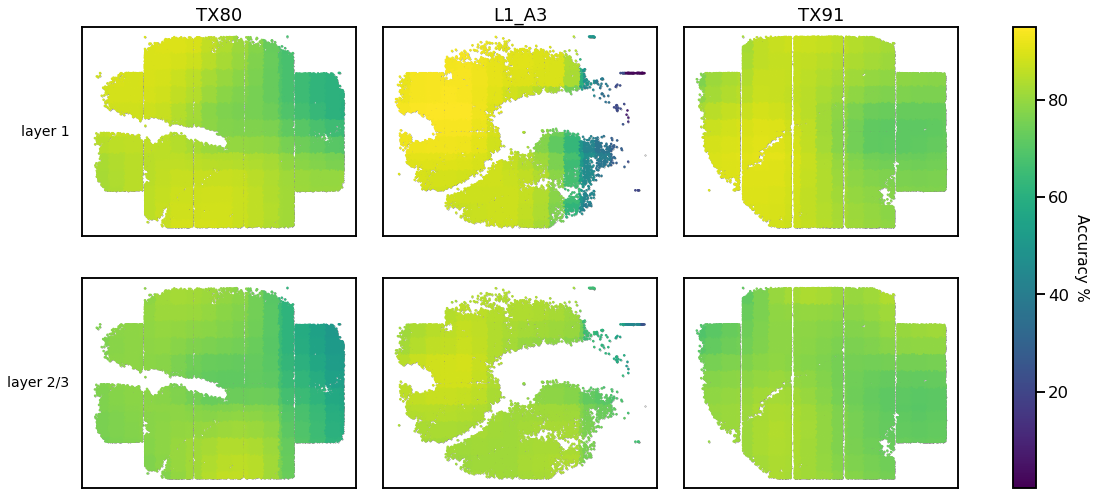

In [ ]:
lyr = 2
s = len(Sessions[3:])
f, axs = plt.subplots(lyr, s, figsize=(19,8))
vmin, vmax = get_min_max_acc(Sessions[3:])
cm = plt.cm.get_cmap('viridis')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.2)
for s, sess in enumerate(Sessions[3:]):
    for l in range(lyr):   
        mask = ~np.isnan(np.array(sess.acc_layer_neuron[l]).astype('float64'))
        axs[l,s].scatter(sess.xpos,-sess.ypos, s=0.2, c = 'gray') 
        im = axs[l,s].scatter(sess.xpos[mask],-sess.ypos[mask], s=1, cmap=cm, c = sess.acc_layer_neuron[l][mask], norm=colors.Normalize(vmin=vmin, vmax=vmax)) 
        axs[l,s].set_xticks([])
        axs[l,s].set_yticks([])
        if l == 0:
            axs[l,s].set_title(f"{sess.name}")
pad = 5 
for ax, row in zip(axs[:,0], ["layer 1", "layer 2/3"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=14, ha='right', va='center')
cbar = f.colorbar(im, ax=axs.ravel().tolist())
cbar.set_label('Accuracy %', rotation=270, size=15,  labelpad=20)
plt.show()

In [66]:
Sessions[5].acc_layer_neuron[0]

array([nan, 74.55357142857143, 76.11607142857143, ..., 86.83035714285714,
       nan, 84.00297619047619], dtype=object)

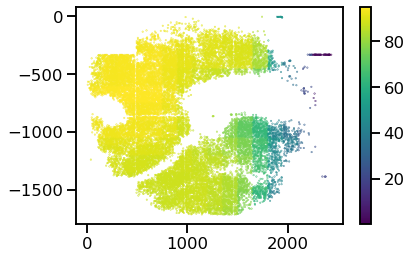

In [73]:
sc = plt.scatter(Sessions[4].xpos[~np.isnan(Sessions[4].acc_layer_neuron[0].astype('float64'))],-Sessions[4].ypos[~np.isnan(Sessions[4].acc_layer_neuron[0].astype('float64'))], s=0.2, cmap='viridis', c = Sessions[4].acc_layer_neuron[0][~np.isnan(Sessions[4].acc_layer_neuron[0].astype('float64'))])
plt.colorbar(sc)

posx and posy should be finite values


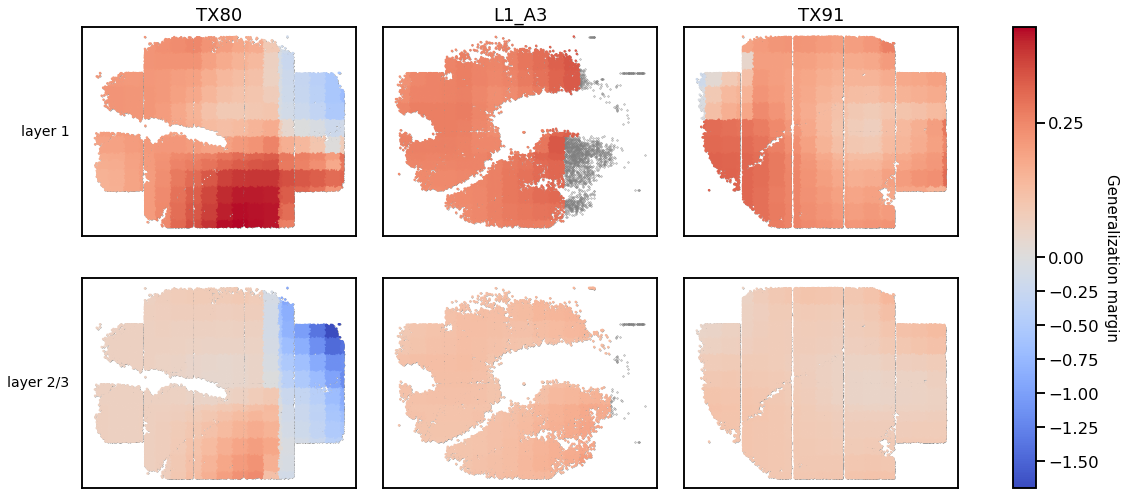

In [ ]:
lyr = 2
s = len(Sessions[3:])
from scipy import stats
vmin, vmax = get_min_max_marg(Sessions[3:])
f, axs = plt.subplots(lyr, s, figsize=(19,8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.2)
cm = plt.cm.get_cmap('coolwarm')
for s, sess in enumerate(Sessions[3:]):
    for l in range(lyr):   
        mask = ~np.isnan(np.array(sess.marg_layer_neuron[l]).astype('float64'))
        c = sess.marg_layer_neuron[l][mask].astype(float)
        axs[l,s].scatter(sess.xpos,-sess.ypos, s=0.2, c = 'gray') 
        im = axs[l,s].scatter(sess.xpos[mask],-sess.ypos[mask], s=1, cmap=cm, c = c, norm=colors.TwoSlopeNorm(vcenter = 0, vmin=vmin, vmax=vmax)) 
        axs[l,s].set_xticks([])
        axs[l,s].set_yticks([])
        if l == 0:
            axs[l,s].set_title(f"{sess.name}")
pad = 5 
for ax, row in zip(axs[:,0], ["layer 1", "layer 2/3"]):
     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
              xycoords=ax.yaxis.label, textcoords='offset points',
               size=14, ha='right', va='center')
cbar = f.colorbar(im, ax=axs.ravel().tolist())
cbar.set_label('Generalization margin', rotation=270, size=15, labelpad=20)
plt.show()